In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import yaml 
import sys
sys.path.append('./../..')
from dynaphos import utils

import pandas as pd 
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.stats import linregress, norm

# import tqdm
# from tqdm.notebook import trange, tqdm
from tqdm.autonotebook import tqdm as notebook_tqdm


# plt.rcParams.update({
#     'axes.labelsize': 'large',
#     'font.size': 14,
#     'lines.linewidth': 2.5})


# #colors for plots, to fit with theme for prettiness
# color1 = '#326e5e' #dark-turquoise
# color2 = '#63c4ab' #turquoise
# color3 = '#AFE4DE'

# c_list_turq = [color1,color2,color3]

# #donders color scheme
# color1 = '#8b0203' #dark red
# color2 = '#ba1319' #medium red
# color3 = '#ed1c24' #light red
# color4 = '#dd8a8d' #very light red (light red low opacity)

# c_list_red = [color1,color2,color3,color4]


# c_list_orange = ['#ffb700', '#c48d02', '#ffcd4f']

COLORSTYLE = utils.load_params('../_figurestyle/colors.yaml')
plt.style.use('../_figurestyle/small.mplstyle')


/scratch/jaap/miniconda3/envs/rl-mobility/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

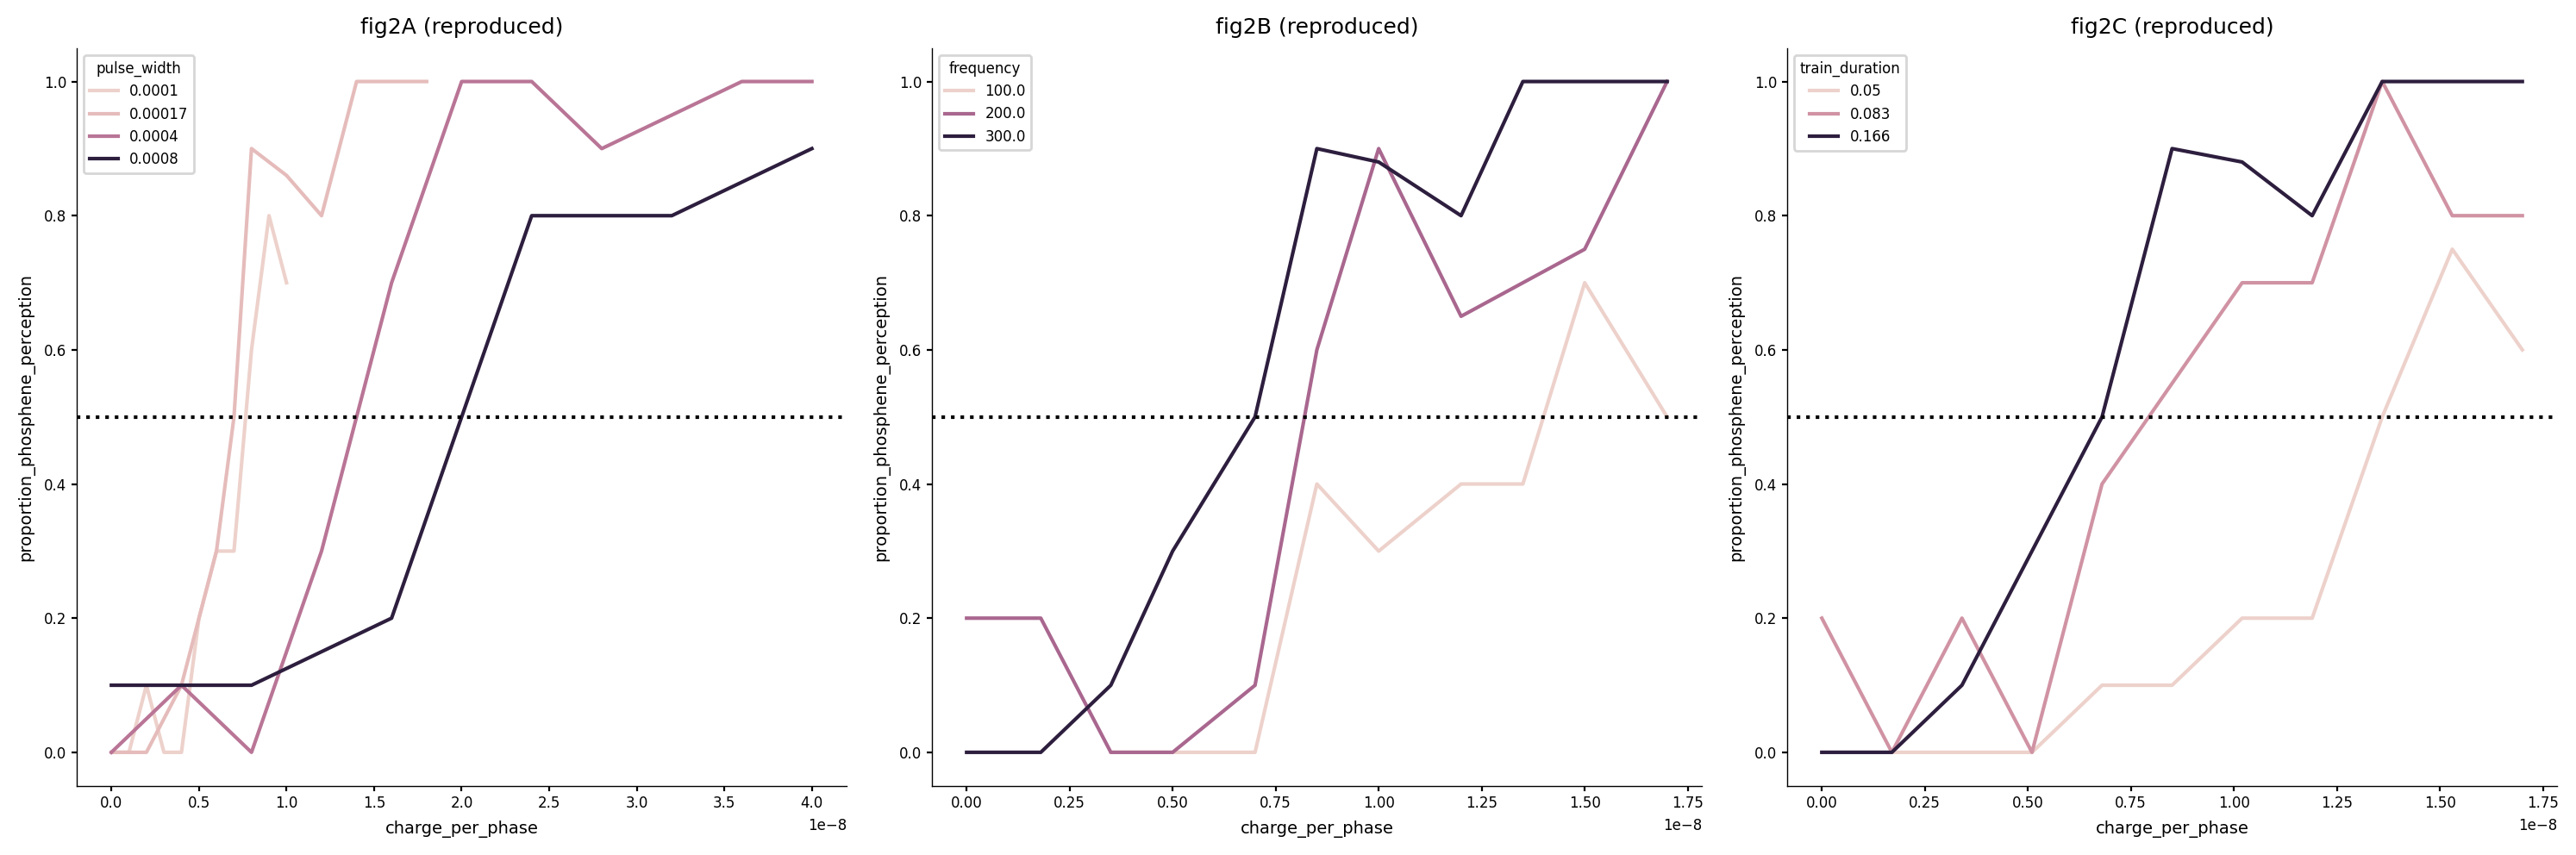

In [128]:
# Default stimulation parameters in Fernandez et al 2021
DEFAULT = pd.Series({'pulse_width'    : 170e-6,
                     'frequency'      : 300,
                     'train_duration' : 166e-3})

# Proportion of phosphene perception in figure 2 Fernandez et al 2021
PROPORTIONS = pd.read_csv('data/Fernandez_et_al_2021_fig2.csv',float_precision='high')

# 50 percent detection thresholds (based on the fit by Fernandez et al fig 2)
THRESHOLDS  = pd.read_csv('data/Fernandez_et_al_2021_fig2_50perc_thresholds.csv',float_precision='high')


## VISUALIZE
fig, axs = plt.subplots(1,3,figsize=(15,5),dpi=200)
for i, (label, param) in enumerate([ ('fig2A','pulse_width'),
                                    ('fig2B','frequency'),
                                    ('fig2C','train_duration')]): 
    sns.lineplot(data=PROPORTIONS.loc[PROPORTIONS.label==label],
                 x='charge_per_phase',
                 y='proportion_phosphene_perception',
                 hue=param,
                 ax = axs[i])
    axs[i].set(title=f'{label} (reproduced)')
    axs[i].axhline(0.5, color='k', linestyle=':')

plt.tight_layout()

## Uncomment to look at the detection thresholds
# THRESHOLDS

#### Calculate other descriptive parameters
e.g. the minimal stim. amplitude, charge per trial, etc

In [3]:
def add_complementary_parameters(data):
    data['amplitude']  = data.charge_per_phase/data.pulse_width 
    data['charge_per_trial'] = data.charge_per_phase * data.frequency * data.train_duration 
    data['duty_cycle'] = data.pulse_width*data.frequency
    data['corrected_duration'] = data.duty_cycle * data.train_duration
    return data

# Calculate other descriptive parameters and add to the dataframe
add_complementary_parameters(PROPORTIONS)
add_complementary_parameters(THRESHOLDS)

,pulse_width,frequency,train_duration,charge_per_phase,label,amplitude,charge_per_trial,duty_cycle,corrected_duration
0,0.00010,300,0.166,7.500000e-09,fig2A,0.000075,3.735000e-07,0.030,0.004980
1,0.00017,300,0.166,7.000000e-09,fig2A,0.000041,3.486000e-07,0.051,0.008466
2,0.00040,300,0.166,1.600000e-08,fig2A,0.000040,7.968000e-07,0.120,0.019920
3,0.00080,300,0.166,2.000000e-08,fig2A,0.000025,9.960000e-07,0.240,0.039840
4,0.00017,100,0.166,1.400000e-08,fig2B,0.000082,2.324000e-07,0.017,0.002822
5,0.00017,200,0.166,9.000000e-09,fig2B,0.000053,2.988000e-07,0.034,0.005644
6,0.00017,300,0.166,6.000000e-09,fig2B,0.000035,2.988000e-07,0.051,0.008466
7,0.00017,300,0.050,1.390000e-08,fig2C,0.000082,2.085000e-07,0.051,0.002550
8,0.00017,300,0.083,8.500000e-09,fig2C,0.000050,2.116500e-07,0.051,0.004233
9,0.00017,300,0.166,6.300000e-09,fig2C,0.000037,3.137400e-07,0.051,0.008466


## Fit the threshold parameters (rheobase and chronaxie)


In [4]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import linregress


data = THRESHOLDS.copy()


# charge-duration curve
CD_fit = lambda duration,rheobase,chronaxie: rheobase*duration + chronaxie*rheobase
x, y = data.corrected_duration, data.charge_per_trial
fitParam, fitCov = curve_fit(CD_fit,x,y)
rheobase, chronaxie = fitParam

# strength-duration curve
SD_fit = lambda duration,rheobase,chronaxie: rheobase*(1+chronaxie/duration)

### UNCOMMENT TO FIT ON AMPLITUDES INSTEAD OF CHARGE PER TRIAL 
# x, y = data.corrected_duration, data.amplitude
# fitParam, fitCov = curve_fit(SD_fit,x,y)
# rheobase, chronaxie = fitParam

# CALCULATE R-squared

def r_squared(xdata,ydata,ypred):
    residuals = ydata - ypred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

r2_cpt = r_squared( xdata = data['corrected_duration'],
                    ydata = data['charge_per_trial'],
                    ypred = data['corrected_duration']*rheobase + chronaxie*rheobase)
print(f'R^2 : {r2_cpt}')

R^2 : 0.915228846944883


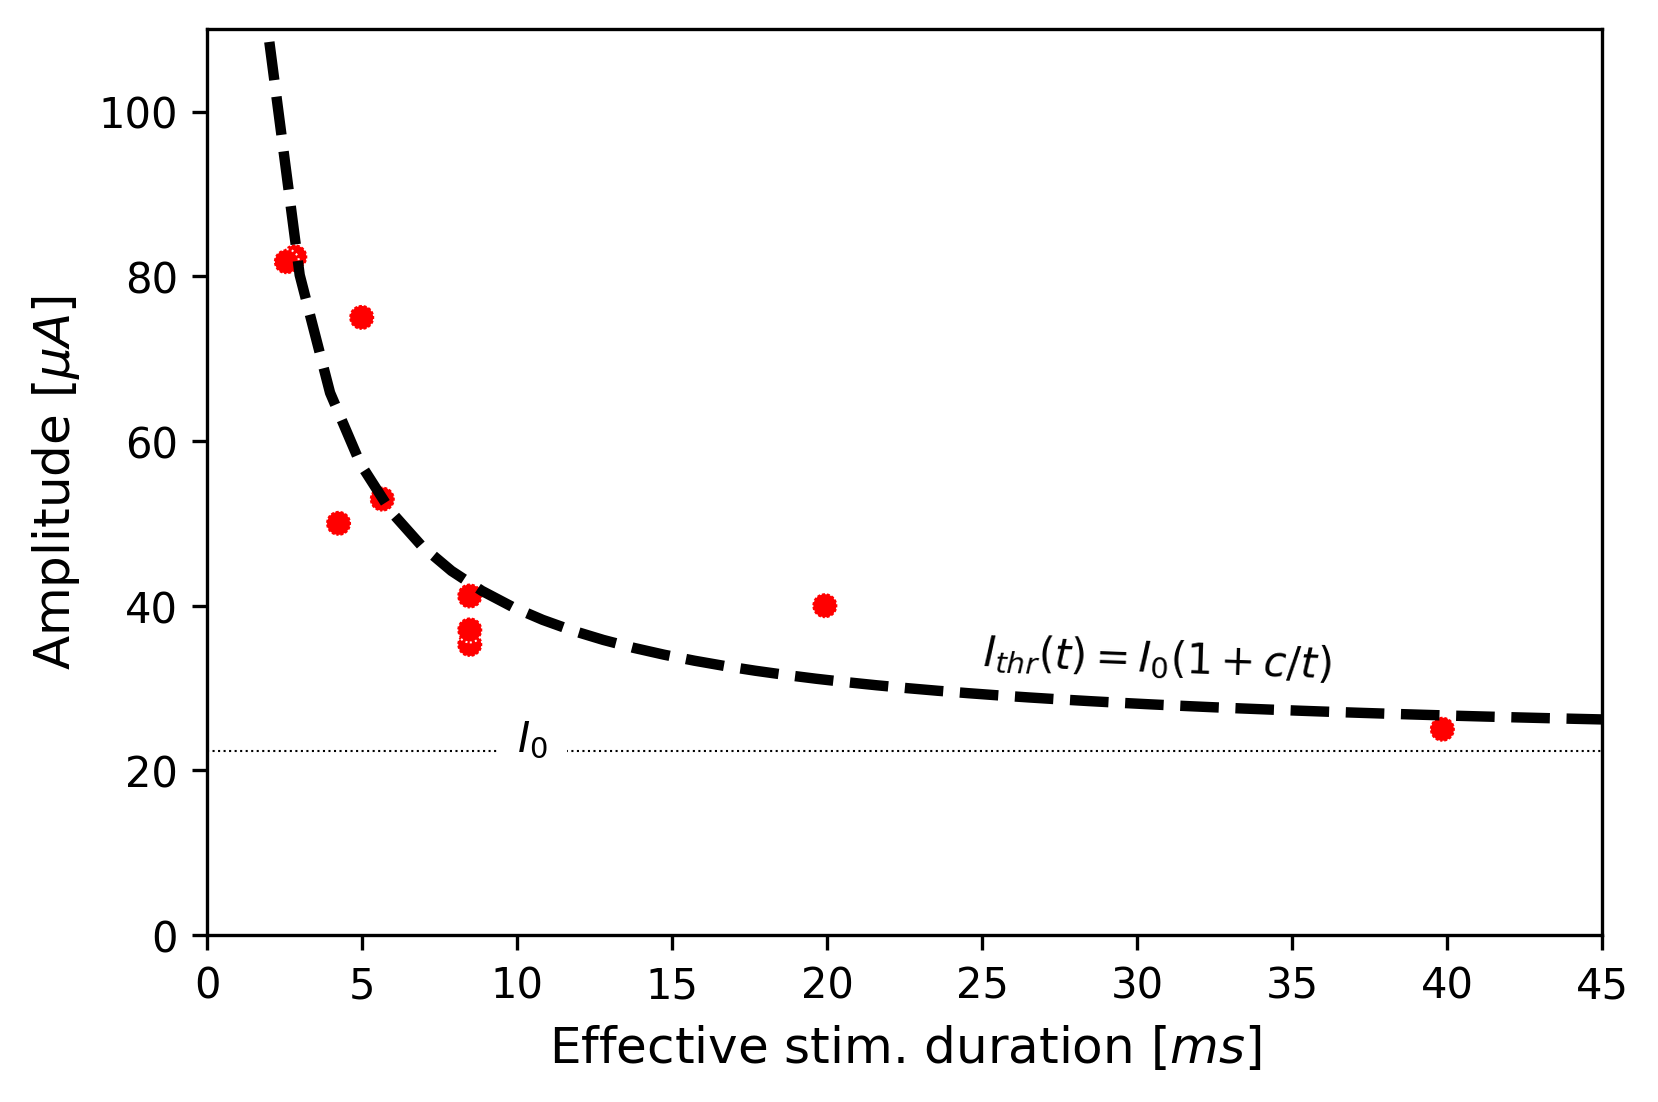

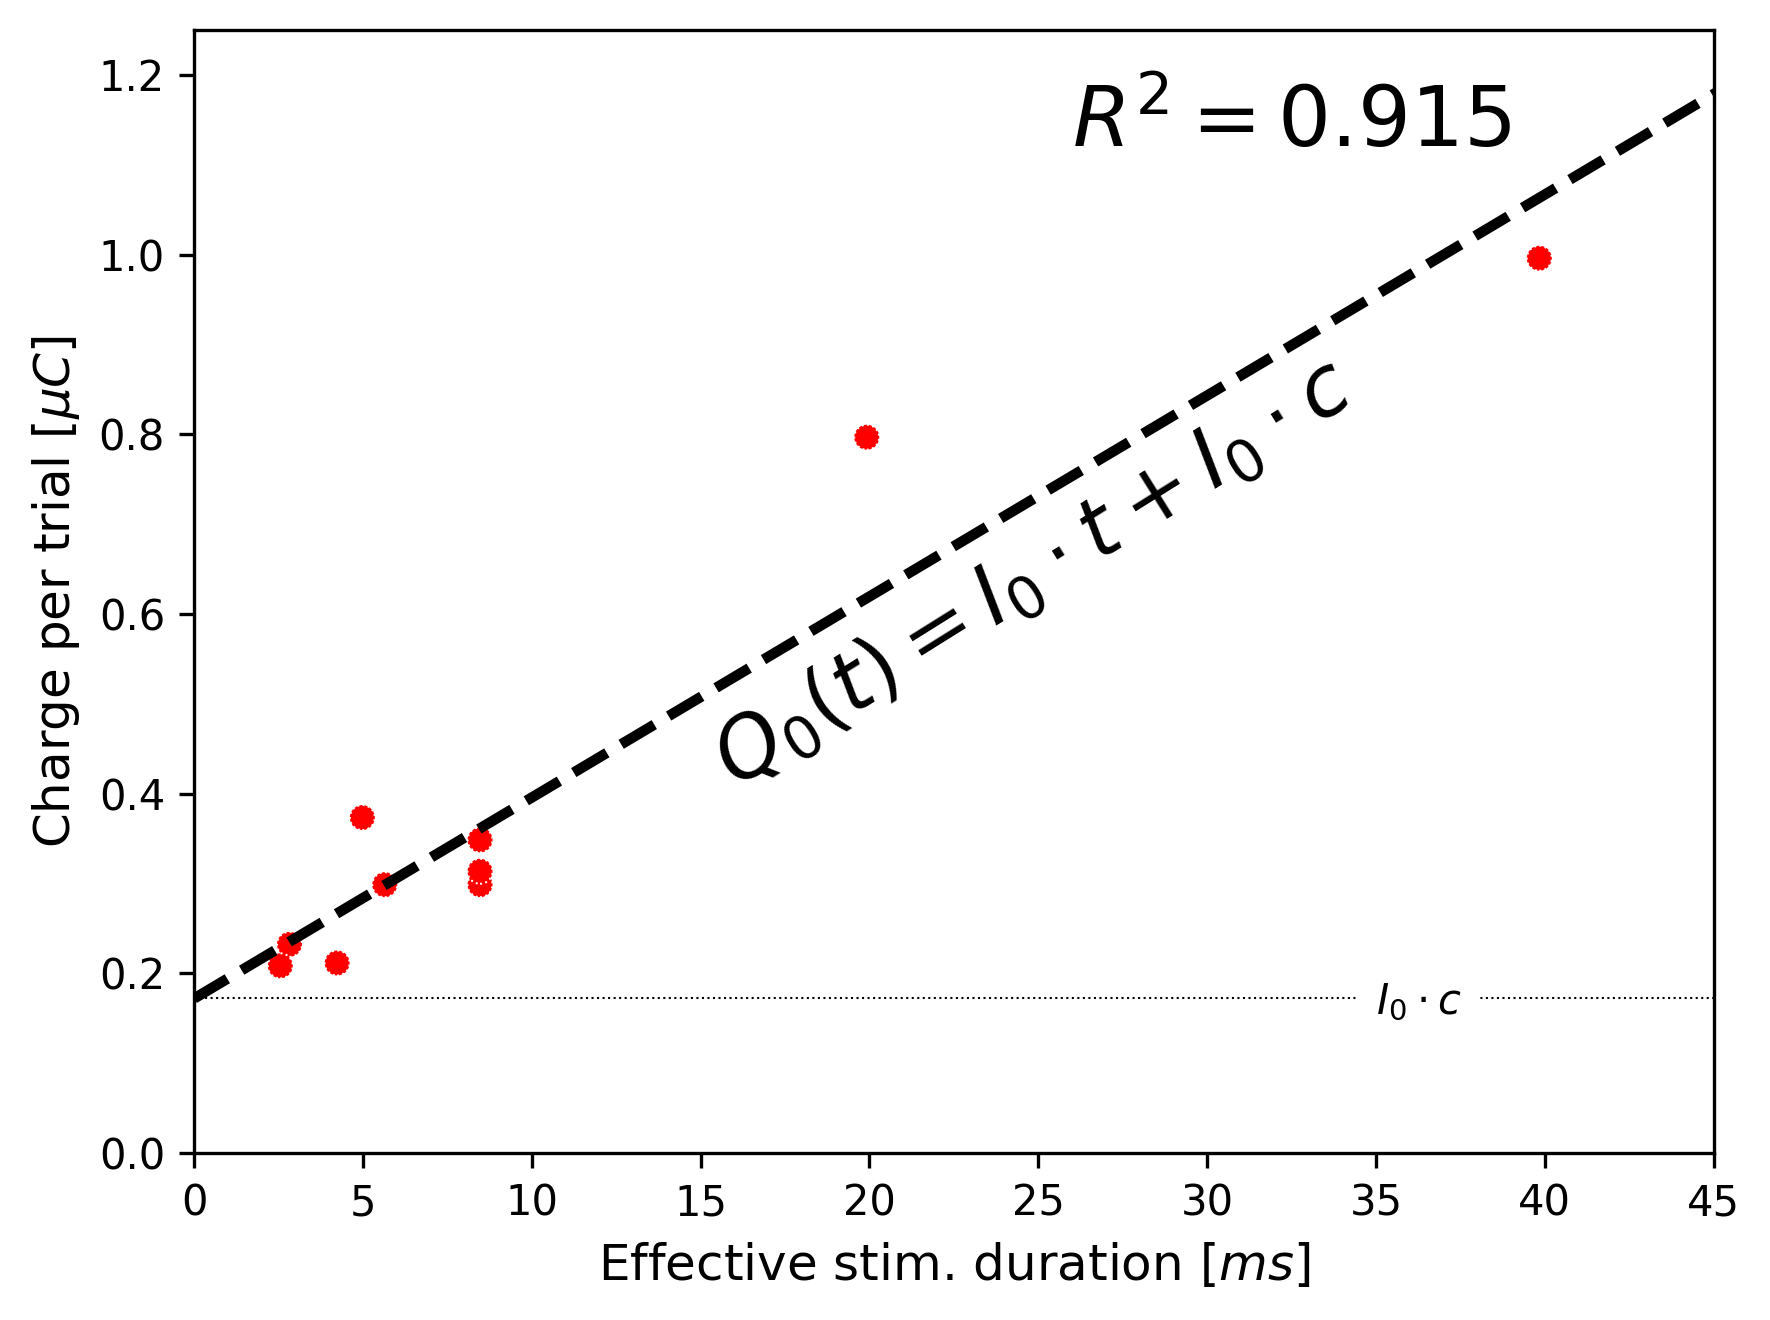

In [5]:
#### Visualize


### 1.  Amplitude curve
fig, ax = plt.subplots(1,1,figsize=(6,4), dpi=300,)
t = np.linspace(0.002,0.05,50)
sns.scatterplot(x=data.corrected_duration*1e3,
                y=data.amplitude *1e6,
                linestyle = ':',
                hue=None,
                ax=ax,
                c=['r']*len(data))

ax.set(xlabel='Effective stim. duration [$ms$]',
           ylabel='Amplitude [$\mu A$]',
           xlim = [0,45],
           ylim = [0,110])


# # line for the rheobase (I_0)
ax.axhline(rheobase*1e6, color='k', linestyle=':', linewidth=0.5,)
ax.text(10,rheobase*1e6, '$I_0$',  bbox={'color':'white','fill':True})

# line and text for the amplitude curve fit
ax.plot(t*1e3, SD_fit(t,rheobase,chronaxie)*1e6, 'k--')
ax.text(25, rheobase *1.4e6, 
            '$I_{thr}(t) = I_0 (1 + c / t)$',
            rotation = -2,)

### 2. Charge plot
fig, ax = plt.subplots(1,1,figsize=(6,4.5), dpi=300,)
t = np.linspace(0.000,0.05,50)
sns.scatterplot(x=data.corrected_duration*1e3,
                y=data.charge_per_trial *1e6,
                linestyle = ':',
                hue=None,
                ax=ax,
                c=['r']*len(data))
ax.set(xlabel='Effective stim. duration [$ms$]',
           ylabel='Charge per trial [$\mu C$]',
           ylim = [0,1.25],
           xlim = [0,45] )

# Line for the intercept (rheobase x chronachie <==> I_0 x c)
ax.axhline(rheobase*chronaxie*1e6, color='k', linestyle=':', linewidth=0.5,)
ax.text(35,rheobase*chronaxie*0.9e6, '$I_0 \cdot c$',  bbox={'color':'white','fill':True})

## Line and text for the curve fit
ax.plot(t*1e3, (t*rheobase + chronaxie*rheobase)*1e6, 'k--')
ax.text(15, (15e-3 * rheobase + chronaxie*rheobase-1e-7)*1e6, 
            '$Q_0(t) = I_0 \cdot t + I_0 \cdot c$',
            fontsize=20,
            rotation = 32,)

# Text with R^2 value
ax.text(39,1.12,f'$R^2 = {r2_cpt:0.3f}$',
            bbox={'color':'white','fill':True},
            fontsize = 20, horizontalalignment = 'right')

plt.tight_layout()

## Fit the activation threshold with the psychometric curves 

In [6]:
def get_additional_stim_data(n_datapoints=150, I_max=120e-6, ):
    """Produce some new stimulation datapoints, for evaluating the (simulated) effects. 
    Using more datapoints can be helpful for a smooth visualization of the modelled responses."""
    i = np.linspace(0.,I_max, n_datapoints)
    pws = np.array([100e-6, 170e-6, 400e-6,800e-6,])
    fs = np.array([100.,200.,300.])
    dur = np.array([50.*1e-3, 83.*1e-3, 166.*1e-3])
    
    PW, F, TD, I = np.meshgrid(pws,fs,dur,i) ### all permutations of I, pw fs and duration
    data = pd.DataFrame({'pulse_width': PW.flatten(), 
                         'frequency': F.flatten(),
                         'train_duration': TD.flatten(),
                         'amplitude': I.flatten(),
                         'mask_pulse_width': False,
                         'mask_frequency': False,
                         'mask_train_duration': False})
    data['charge_per_phase']  = data.amplitude*data.pulse_width 
    data['charge_per_trial'] = data.charge_per_phase * data.frequency * data.train_duration 
    
    # 
    data.loc[(data.frequency == DEFAULT.frequency) & (data.train_duration == DEFAULT.train_duration), 'mask_pulse_width'] = True
    data.loc[(data.pulse_width == DEFAULT.pulse_width) & (data.train_duration == DEFAULT.train_duration), 'mask_frequency'] = True
    data.loc[(data.frequency == DEFAULT.frequency) & (data.pulse_width == DEFAULT.pulse_width), 'mask_train_duration'] = True
    return data



In [7]:
FPS = 1000

def run_experiment(X_IN,
                   trace_decay_constant = -np.log( 0.99949191),
                   trace_increase_rate = 13.95528162,
                   act_decay_constant = 9.,
                   rheobase = 23.9e-6,
                   pulse_width = 100e-6,
                   frequency = 200,
                   dt = 1/32,):
    
    # Stimulation sequence
    stim = X_IN.copy()
    n_steps = len(stim)
    T = n_steps*dt

    # Initialize output arrays
    stim_input = np.zeros(n_steps) # JR: effective stimulation
    trace = np.zeros(n_steps) #long-term memory trace
    activation = np.zeros(n_steps) #output
    leak = np.zeros(n_steps)

    
    #run experiment
    for t in range(n_steps):
        
        ## TODO: REMOVE!!!
#         trace = np.zeros(n_steps) 
        
        if t>0:
            
            # remainder after decay from previous time step
            activation[t] = activation[t-1]
            activation[t] -= act_decay_constant * activation[t-1] * dt

            # new input
            leak_current  = trace[t-1] + rheobase
            
#             # TODO: REMOVE!!!
#             leak_current  = 0
            
            
            stim_input[t] = (stim[t] - leak_current) * pulse_width * frequency 
            stim_input[t] = max(0,stim_input[t]) 
            activation[t] += stim_input[t] * dt 

            # trace update 
            trace[t] = trace[t-1]
            trace[t] -= trace_decay_constant * trace[t-1] * dt
            trace[t] += trace_increase_rate * stim_input[t] * dt
            

            
            leak[t]  = leak_current
            
        else:
            # In the first frame, ignore the previous time step (there is none)
            stim_input[t] = (stim[t] - rheobase) * pulse_width * frequency * dt 
            stim_input[t] = max(0,stim_input[t])
            activation[t] += stim_input[t]
            
            leak[t]  = rheobase
    
    return activation, trace, stim


## The simulator model
def get_max_activation(amplitude=90e-6,     
                       pulse_width=170e-6,
                       frequency=300,
                       stim_duration=166e-3,
                       rheobase=23.9e-6,
                       act_decay_constant = 9,
                       fps=1000):
    
    sequence = get_stim_sequence(stim_duration, amplitude, fps)

    activation, trace, stim = run_experiment(sequence,
                                             pulse_width = pulse_width,
                                             frequency = frequency,
                                             rheobase = rheobase,
                                             act_decay_constant = act_decay_constant,
                                             dt = 1/fps)

        
    return activation.max()

def get_stim_sequence(stim_duration=166e-3, amplitude=90e-6, fps=1000,):
    stim_frames = int(stim_duration*fps)
    sequence = np.concatenate([np.ones(stim_frames), np.zeros(fps-stim_frames)])
    return amplitude * sequence




In [13]:


def calc_modeled_activation(data, fps=1000, rheobase=23.9e-6,act_decay_constant = 9.,trace_decay_constant = -np.log( 0.99949191),trace_increase_rate = 13.95528162,):
    # Simplified model output 
    data['total_charge_loss_'] = rheobase * data.pulse_width * data.frequency * data.train_duration
    data['total_effective_charge_'] = data.charge_per_trial - data.total_charge_loss_

    activations = []
    traces = []
    stimulations = []
    
    # Model output after providing stimulation sequence
    for i,specs in notebook_tqdm(data.iterrows(), total=len(data)):

        sequence = get_stim_sequence(stim_duration=specs.train_duration,
                                     amplitude=specs.amplitude,
                                     fps=fps)

        activation, trace, stim = run_experiment(sequence,
                                                 pulse_width = specs.pulse_width,
                                                 frequency = specs.frequency,
                                                 rheobase=rheobase,
                                                 act_decay_constant = act_decay_constant,
                                                 trace_decay_constant = trace_decay_constant,
                                                 trace_increase_rate = trace_increase_rate,
                                                 dt = 1/fps)
        
        
        
        data.loc[i,'max_activation_'] = activation.max()
        
        activations.append(activation)
        traces.append(trace)
        stimulations.append(stim)

    return activations, traces, stimulations



In [14]:
import sys
sys.path.append('./../..')
from dynaphos import utils
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
# import init

params = utils.load_params('../../config/params.yaml')

In [15]:
ACTIVATION_DECAY = -np.log(params['temporal_dynamics']['activation_decay_per_second'])
TRACE_DECAY = -np.log(params['temporal_dynamics']['trace_decay_per_second'])
TRACE_INCREASE = params['temporal_dynamics']['trace_increase_rate']


# Copy the datapoints from Fernandéz et al
data = PROPORTIONS.copy()

# Get some additional stimulation data (virtual datapoints, for simulation)
virtual_data = get_additional_stim_data(n_datapoints=1000, I_max=150e-6) # to create a smooth curve of the predicted response

# Calculate the modelled activation (run experiments for each of the datapoints)
calc_modeled_activation(data,
                        act_decay_constant= ACTIVATION_DECAY,
                        trace_decay_constant = TRACE_DECAY,
                        trace_increase_rate = TRACE_INCREASE,
                        
                   )
activations, traces, stimulations = calc_modeled_activation(virtual_data,
                                                            act_decay_constant= ACTIVATION_DECAY,
                                                            trace_decay_constant = TRACE_DECAY,
                                                            trace_increase_rate = TRACE_INCREASE) #, act_decay_constant = 1.)

100%|████████████████████████████████████| 36000/36000 [02:03<00:00, 291.07it/s]


estimated activation threshold: 9.14188600094388e-08, sigma: 6.715877869833961e-08, 
R^2: 0.868


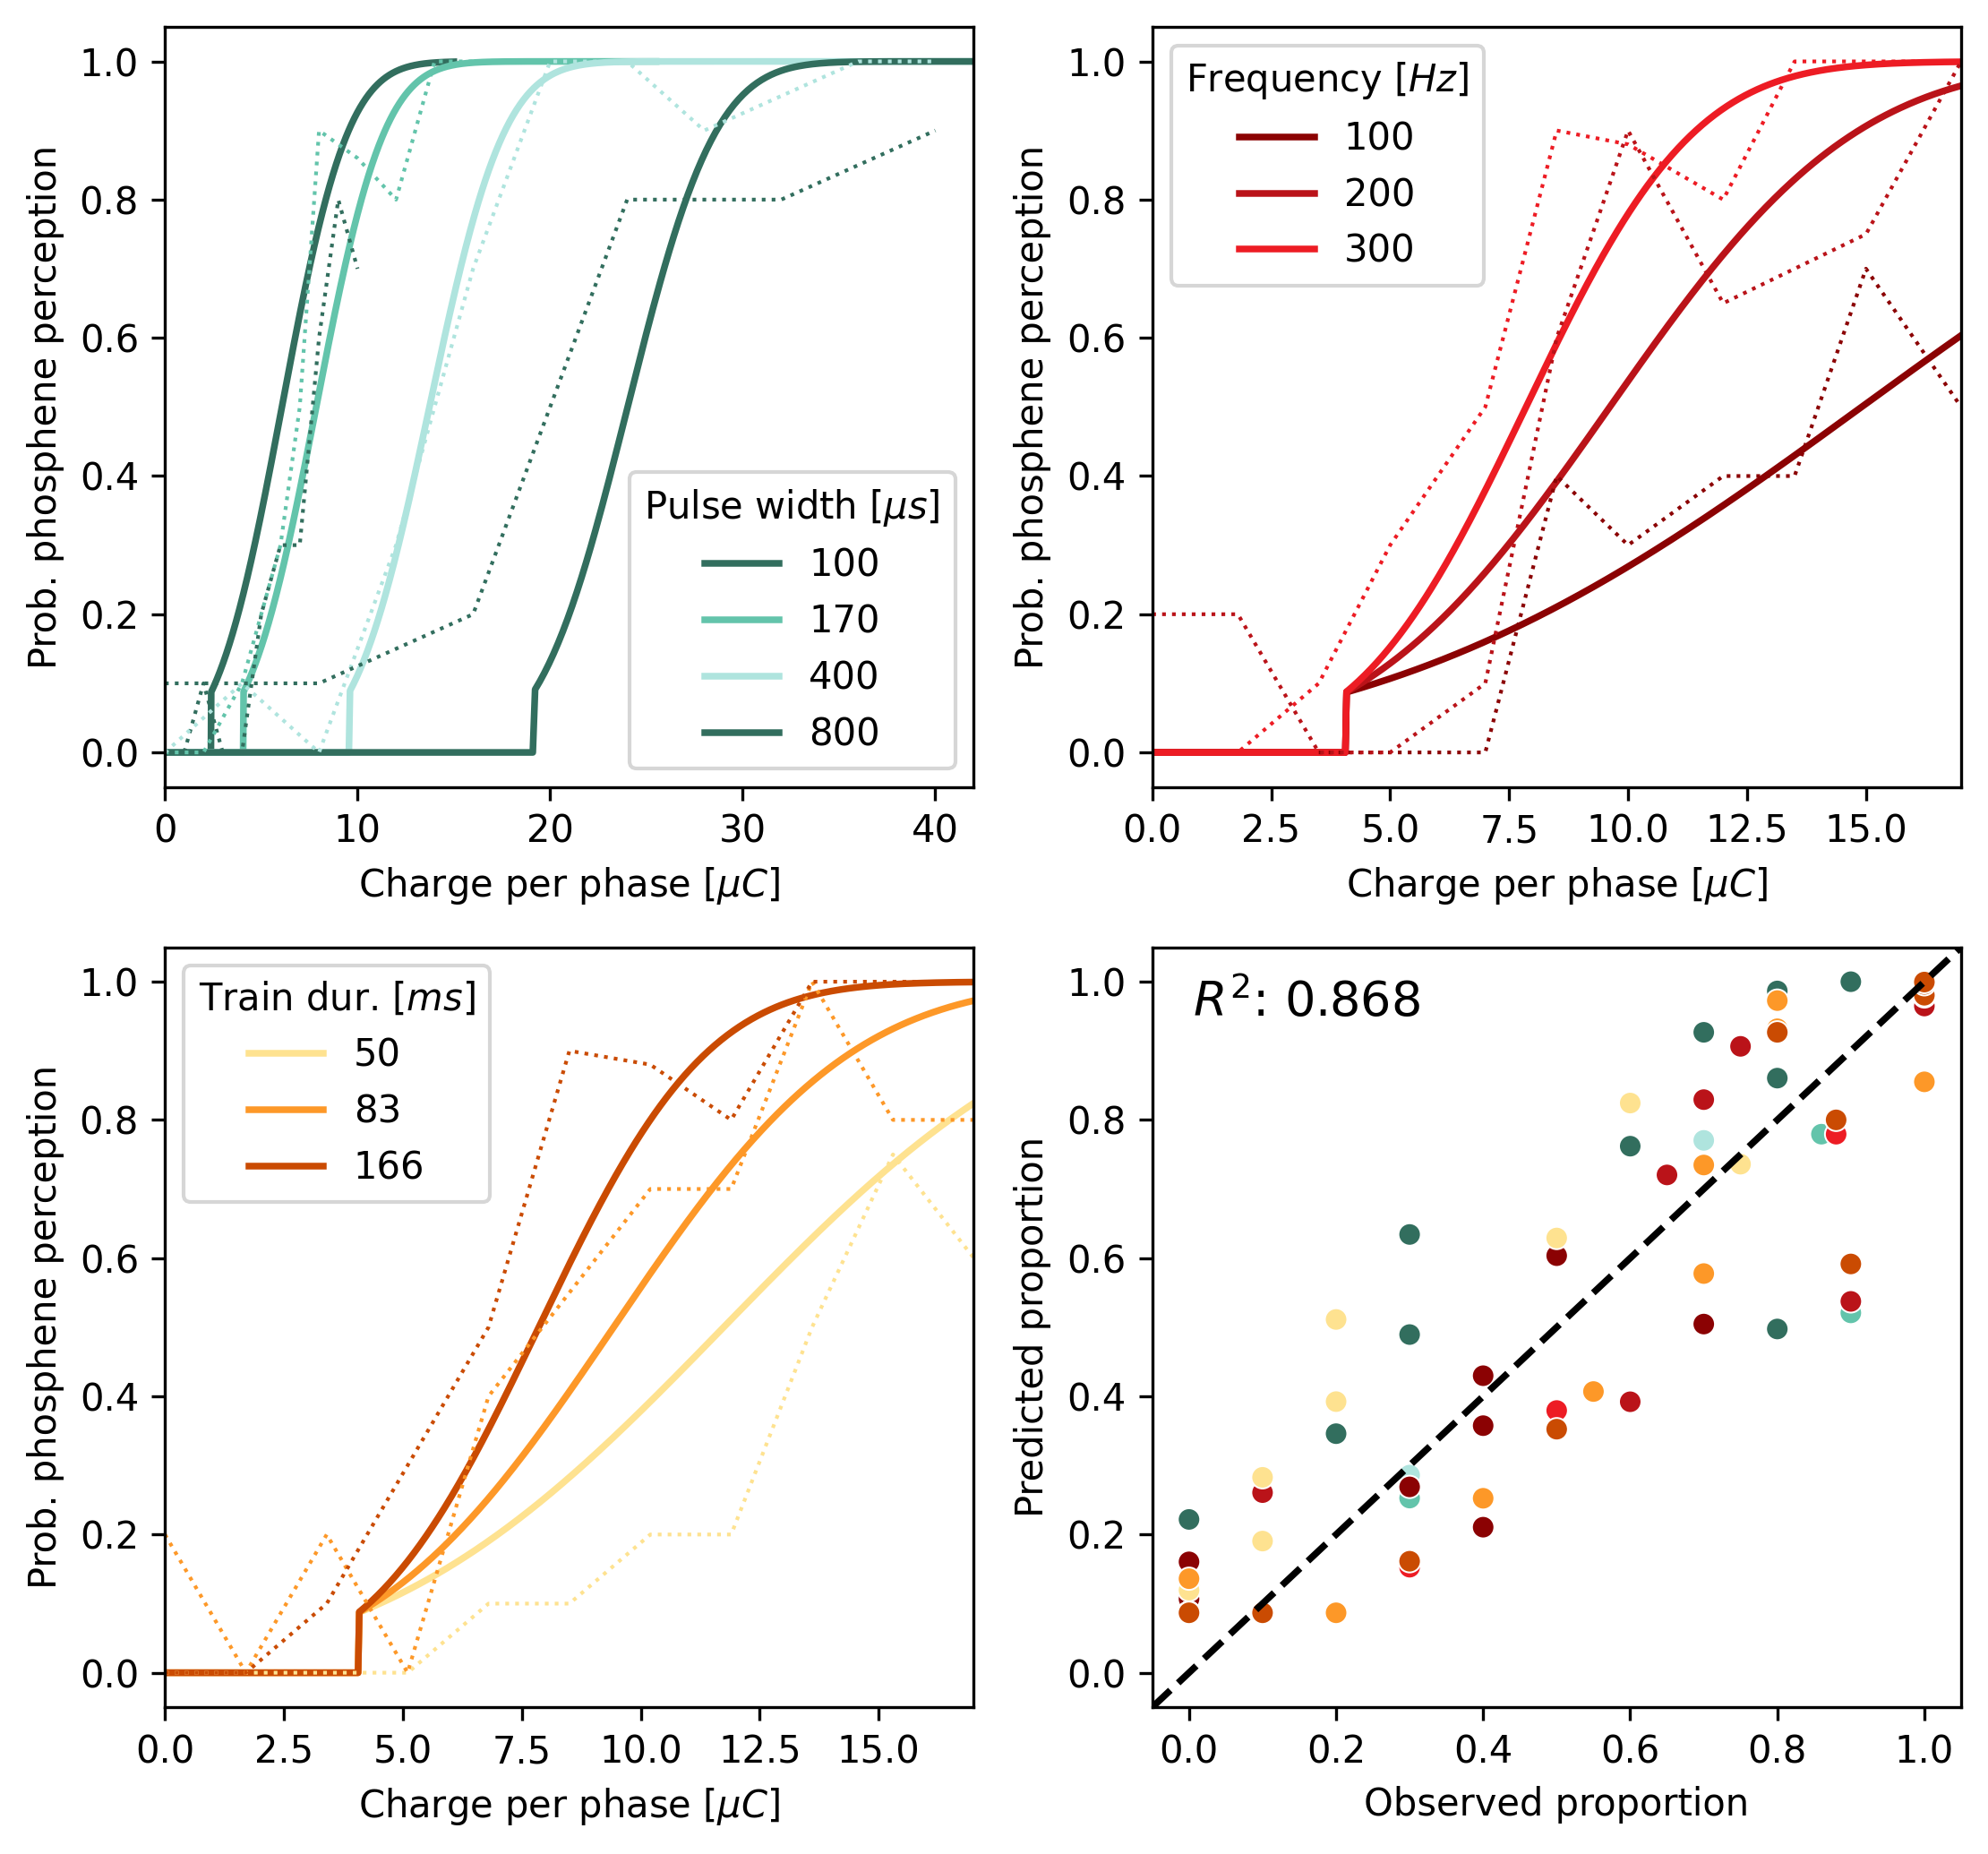

In [32]:
PLOT_ZERO_ACTIVATIONS = 'standard' # choose: 'standard', 'ignore', 'crosses'


# Estimated proportion of active phosphenes as function of effective charge (normal cumulative density func.)
func_prob = lambda tissue_act, sigma: norm.cdf(tissue_act, loc=rheobase*chronaxie, scale=sigma) 

# # Curve fit (MODEL: max_activation_)
func_prob = lambda x, mu=5.9307288148088016e-08, sigma=4.3836315254409424e-08: norm.cdf(x, mu, sigma)

x = data.max_activation_
y_true = data.proportion_phosphene_perception
(A_thr,sigma,), _ = curve_fit(func_prob, x, y_true, p0=[50e-9, 2.2e-7], bounds=[[1e-11, 1.0e-10],[1e-6, 1.0e-5]])

y_pred = func_prob(data.max_activation_, mu=A_thr, sigma=sigma)
regress = linregress(y_true,y_pred)
print(f'estimated activation threshold: {A_thr}, sigma: {sigma}, \nR^2: {regress.rvalue**2:.3f}')

# Interpolated data points (for smooth prediction curve)
x_interp = virtual_data.max_activation_
y_pred_interp = func_prob(x_interp, mu=A_thr, sigma=sigma)
y_pred_interp[virtual_data.max_activation_ == 0] = 0

fig, axs = plt.subplots(2,2, figsize=(7.5,7), dpi=300)
for i, (label, param, colors, xlim,) in enumerate([ ('fig2A','pulse_width', COLORSTYLE['turquoise'], [0,42],),
                                                     ('fig2B','frequency', COLORSTYLE['red'], [0,17]),
                                                     ('fig2C','train_duration', COLORSTYLE['orange'], [0,17])]):  #[0,17])]): 
   
    # Zero activations



    # Mask (select the datapoints for the correct experimental parameter: pw, f or td)
    mask = virtual_data[f'mask_{param}'].copy()
    
    
    if PLOT_ZERO_ACTIVATIONS == 'crosses':
        # Change zero activation into crosses 
        zero_activation = (virtual_data.max_activation_  == 0) # mask for the zero_activations
        sns.scatterplot(x=virtual_data.charge_per_phase[mask  & zero_activation]*1e9,
                     y=y_pred_interp[mask & zero_activation],
                     hue=virtual_data.loc[mask & zero_activation,param],
                     ax=axs.flatten()[i],
                     palette=sns.color_palette(colors, n_colors=len(virtual_data[param].unique() )), 
                     marker = 'x',
                     s=15,
                     alpha = 0.5,
                     linewidths=1.)
        
    if PLOT_ZERO_ACTIVATIONS == 'ignore' or PLOT_ZERO_ACTIVATIONS == 'crosses': 
        # Don't plot a line for the zero activation 
        nonzero_activation = ~(virtual_data.max_activation_  == 0) # mask for the nonzero activations
        mask = mask & nonzero_activation


    sns.lineplot(x=virtual_data.charge_per_phase[mask]*1e9,
                 y=y_pred_interp[mask],
                 hue=virtual_data.loc[mask,param],
                 ax=axs.flatten()[i],
                 palette=sns.color_palette(colors, n_colors=len(virtual_data[param].unique() )), 
                 linestyle='-',
                 linewidth=1.8)
    

    
    # Lineplot (data)
    mask = data.label==label
    sns.lineplot(x = data.charge_per_phase[mask]*1e9,
                 y = y_true[mask],
                 hue = data.loc[mask,param],
                 palette=sns.color_palette(colors, n_colors=len(data[param].unique() )),
                 ax=axs.flatten()[i],
                 legend=False,
                 linewidth=1.,
                 linestyle = ':')    
    

    axs.flatten()[i].set(xlim=xlim,
                         ylabel = 'Prob. phosphene perception',
                         xlabel = 'Charge per phase [$\mu C$]')
    
    
    # Scatterplot (model vs data)
    mask = data.label==label
    sns.scatterplot(x = y_true,
                    y = y_pred,
                    hue = data.loc[mask,param],
                    palette=sns.color_palette(colors, n_colors=len(data[param].unique() )),
                    ax=axs.flatten()[-1],
                    legend=False)    
    
        
    

# Neater legends (axs 0 to 3)
axs[0][0].legend(['100', '170','400','800'], title='Pulse width [$\mu s$]')
axs[0][1].legend(['100', '200','300'], title='Frequency [$Hz$]')
axs[1][0].legend(['50', '83','166'], title='Train dur. [$ms$]')

# Adjust final 
axs[1][1].axline((0,0),(1,1), linestyle='--',color='k', linewidth=1.8)
axs[1][1].set(ylabel = 'Predicted proportion',
              xlabel = 'Observed proportion',)
axs[1][1].text(0.005,0.95,f"$R^2$: {regress.rvalue**2:.3f}", ha='left',fontsize=13)
plt.tight_layout()

In [27]:
# out = data.copy()
# out['estimated_proportion_phosphene_perception_'] = y_pred
# out.to_csv('results/estimated_proportion_phosphene_perception.csv', index=False)

# out_interp = virtual_data.copy()
# out_interp['estimated_proportion_phosphene_perception_'] = y_pred_interp
# out_interp.to_csv('results/interpolated_estimates_proportion_phosphene_perception.csv', index=False)


# fig.savefig('results/psychometric_curves_threshold.png')

### Reload saved data

In [2]:
data = pd.read_csv('results/estimated_proportion_phosphene_perception.csv')
virtual_data = pd.read_csv('results/interpolated_estimates_proportion_phosphene_perception.csv')

## Different figure size

estimated activation threshold: 9.14188600094388e-08, sigma: 6.715877869833961e-08, 
R^2: 0.868


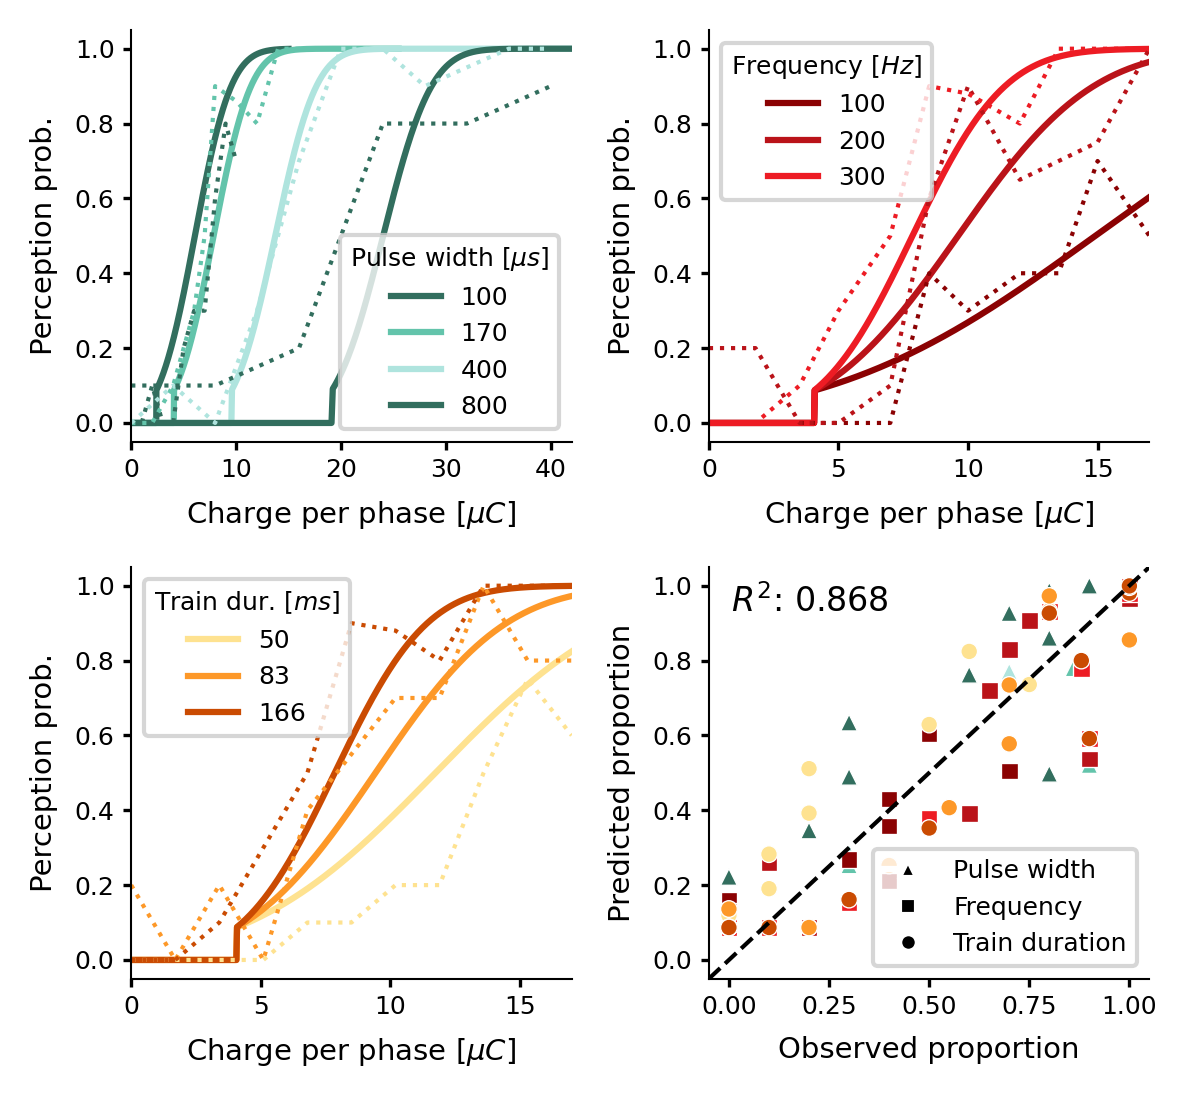

In [5]:
plt.style.use('../_figurestyle/small.mplstyle')
PLOT_ZERO_ACTIVATIONS = 'standard' # choose: 'standard', 'ignore', 'crosses'


# Estimated proportion of active phosphenes as function of effective charge (normal cumulative density func.)
func_prob = lambda tissue_act, sigma: norm.cdf(tissue_act, loc=rheobase*chronaxie, scale=sigma) 

# # Curve fit (MODEL: max_activation_)
func_prob = lambda x, mu=5.9307288148088016e-08, sigma=4.3836315254409424e-08: norm.cdf(x, mu, sigma)

x = data.max_activation_
y_true = data.proportion_phosphene_perception
(A_thr,sigma,), _ = curve_fit(func_prob, x, y_true, p0=[50e-9, 2.2e-7], bounds=[[1e-11, 1.0e-10],[1e-6, 1.0e-5]])

y_pred = func_prob(data.max_activation_, mu=A_thr, sigma=sigma)
regress = linregress(y_true,y_pred)
print(f'estimated activation threshold: {A_thr}, sigma: {sigma}, \nR^2: {regress.rvalue**2:.3f}')

# Interpolated data points (for smooth prediction curve)
x_interp = virtual_data.max_activation_
y_pred_interp = func_prob(x_interp, mu=A_thr, sigma=sigma)
y_pred_interp[virtual_data.max_activation_ == 0] = 0

fig, axs = plt.subplots(2,2, figsize=(4,3.7), dpi=300)
for i, (label, param, colors, xlim,) in enumerate([ ('fig2A','pulse_width', COLORSTYLE['turquoise'], [0,42],),
                                                     ('fig2B','frequency', COLORSTYLE['red'], [0,17]),
                                                     ('fig2C','train_duration', COLORSTYLE['orange'], [0,17])]): #[0,17])]): 
   
    # Zero activations



    # Mask (select the datapoints for the correct experimental parameter: pw, f or td)
    mask = virtual_data[f'mask_{param}'].copy()
    
    
    if PLOT_ZERO_ACTIVATIONS == 'crosses':
        # Change zero activation into crosses 
        zero_activation = (virtual_data.max_activation_  == 0) # mask for the zero_activations
        sns.scatterplot(x=virtual_data.charge_per_phase[mask  & zero_activation]*1e9,
                     y=y_pred_interp[mask & zero_activation],
                     hue=virtual_data.loc[mask & zero_activation,param],
                     ax=axs.flatten()[i],
                     palette=sns.color_palette(colors, n_colors=len(virtual_data[param].unique() )), 
                     marker = 'x',
#                      s=15,
                     alpha = 0.5,
                     linewidths=1.)
        
    if PLOT_ZERO_ACTIVATIONS == 'ignore' or PLOT_ZERO_ACTIVATIONS == 'crosses': 
        # Don't plot a line for the zero activation 
        nonzero_activation = ~(virtual_data.max_activation_  == 0) # mask for the nonzero activations
        mask = mask & nonzero_activation


    sns.lineplot(x=virtual_data.charge_per_phase[mask]*1e9,
                 y=y_pred_interp[mask],
                 hue=virtual_data.loc[mask,param],
                 ax=axs.flatten()[i],
                 palette=sns.color_palette(colors, n_colors=len(virtual_data[param].unique() )), 
                 linestyle='-',)
#                  linewidth=1.8)
    

    
    # Lineplot (data)
    mask = data.label==label
    sns.lineplot(x = data.charge_per_phase[mask]*1e9,
                 y = y_true[mask],
                 hue = data.loc[mask,param],
                 palette=sns.color_palette(colors, n_colors=len(data[param].unique() )),
                 ax=axs.flatten()[i],
                 legend=False,
                 linewidth=1.,
                 linestyle = ':')    
    

    axs.flatten()[i].set(xlim=xlim,
                         ylabel = 'Perception prob.',
                         xlabel = 'Charge per phase [$\mu C$]')
    
    
    # Scatterplot (model vs data)
    mask = data.label==label
    sns.scatterplot(x = y_true,
                    y = y_pred,
                    hue = data.loc[mask,param],
                    palette=sns.color_palette(colors, n_colors=len(data[param].unique() )),
                    ax=axs.flatten()[-1],
                    marker= {'fig2A': '^',
                             'fig2B': 's',
                             'fig2C': 'o',}[label],
                    legend=False)    
    
        
    

# Neater legends (axs 0 to 3)
axs[0][0].legend(['100', '170','400','800'], title='Pulse width [$\mu s$]', loc='lower right')
axs[0][1].legend(['100', '200','300'], title='Frequency [$Hz$]', title_fontsize=6)
axs[1][0].legend(['50', '83','166'], title='Train dur. [$ms$]', title_fontsize=6)

legend_elements = [matplotlib.lines.Line2D([0], [0], color='w', markerfacecolor='k', marker='^', label='Pulse width'),
                   matplotlib.lines.Line2D([0], [0], color='w', markerfacecolor='k', marker='s', label='Frequency'),
                   matplotlib.lines.Line2D([0], [0], color='w', markerfacecolor='k', marker='o', label='Train duration'),]
axs[1][1].legend(handles=legend_elements, loc='lower right', prop={'size': 6,})


# Adjust final 
axs[1][1].axline((0,0),(1,1), linestyle='--',color='k', linewidth=1.)
axs[1][1].set(ylabel = 'Predicted proportion',
              xlabel = 'Observed proportion',)
axs[1][1].text(0.005,0.93,f"$R^2$: {regress.rvalue**2:.3f}", ha='left')
plt.tight_layout()

In [8]:
pd.Series({'50_perc_threshold': 9.14188600094388e-08,
              'sigma': 6.715877869833961e-08,
              'r-squared': regress.rvalue**2}).to_csv('results/parameter_estimates.csv')

In [124]:
fig.savefig('results/resized_psychometric_curves.png')

In [4]:
import matplotlib

# More data inspection:

C:\Users\Jaap\Anaconda3\envs\py36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


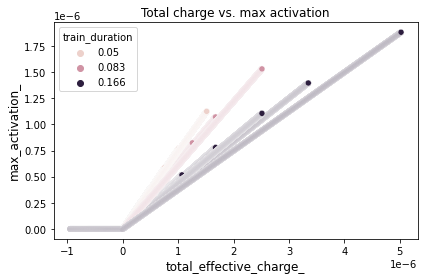

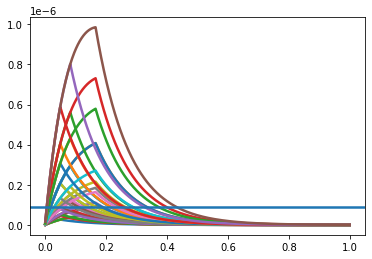

In [23]:
sns.scatterplot(virtual_data.total_effective_charge_, virtual_data.max_activation_, 
               hue = virtual_data.train_duration)
plt.title("Total charge vs. max activation")
plt.tight_layout()
plt.show()




# Visualize the activation curves for one specific stimulation amplitude
activation_curves = pd.DataFrame({f'activation_{i}': act for i,act in enumerate(activations)})

t = np.linspace(0,1,1000) 

AMPL = 90.0e-6
closest = np.abs(AMPL - virtual_data.amplitude.unique()).argmin()
mask = virtual_data.amplitude == virtual_data.amplitude.unique()[closest]

for curve_idx in activation_curves.columns[mask]:
    plt.plot(t,activation_curves[curve_idx], label=curve_idx)
    
plt.axhline(A_thr)
    

In [24]:

diff = [np.diff((a>A_thr)) for a in activations]
locs = [np.where(np.diff((a>A_thr)))[0] for a in activations]
onsets = [peaks[0] if len(peaks)>0 else np.nan for peaks in locs]
offsets = [peaks[1] if len(peaks)>0 else  np.nan for peaks in locs]

virtual_data['onset_'] = np.array(onsets) / FPS
virtual_data['offset_'] = np.array(offsets) / FPS

virtual_data['after_effect_'] =  virtual_data.offset_ - virtual_data.train_duration


<AxesSubplot:xlabel='amplitude', ylabel='after_effect_'>

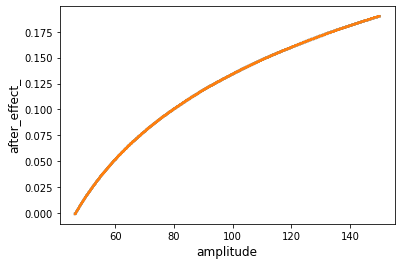

In [25]:
mask = (virtual_data.mask_pulse_width & virtual_data.mask_frequency & virtual_data.mask_train_duration)

sns.lineplot(data=virtual_data.loc[mask], x=virtual_data.amplitude * 1e6, y='after_effect_')
sns.lineplot(data=virtual_data.loc[mask], x=virtual_data.amplitude * 1e6, y='after_effect_')

### Extra validation with the actual simulator

In [29]:
import sys
sys.path.append('./../..')
from dynaphos import utils
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map, get_visual_field_coordinates_probabilistically 


import torch


params = utils.load_params('../../config/params.yaml')

import torch

In [112]:
def run_simulator_experiment(stimulation_sequence, pulse_width, frequency, fps=FPS, n_experiments=50, gpu=None):
    
    # Initialize simulator
    params = utils.load_params('../../config/params.yaml')
    params['cortex_model']['dropout_rate'] = 0
    params['run']['fps'] = fps
    params['thresholding']['use_threshold'] = True
    params['run']['gpu'] = gpu
    coordinates_visual_field = get_visual_field_coordinates_probabilistically(params,n_phosphenes=1)
    simulator = PhospheneSimulator(params.copy(), coordinates_visual_field)
    n_phosphenes = simulator.num_phosphenes
    device = simulator.phosphene_maps.device
    
    # Run several experiments
    results = pd.DataFrame()
    for exp in range(n_experiments):
        simulator.reset()
        simulator.threshold.reinitialize()
        states = []
        for i,stim in enumerate(stimulation_sequence):
            simulator.update(amplitude = torch.ones(n_phosphenes, device=device)*stim,
                             pulse_width = torch.ones(n_phosphenes, device=device)*pulse_width,
                             frequency = torch.ones(n_phosphenes,  device=device)*frequency)
            states.append({k:v.item() for k,v in simulator.get_state().items()})
            states[-1]['amplitude'] = stim
            states[-1]['experiment'] = exp
            states[-1]['time'] = i/FPS
        new = pd.DataFrame(states)
        new['activated'] = new.activation.max() >= new.threshold.max()
        results = pd.concat([results, new], ignore_index=True)
        
    perc_active = results.activated.mean()

        
    return perc_active

In [113]:
perc_active = [] 

# Model output after providing stimulation sequence
for i,specs in notebook_tqdm(data.iterrows(), total=len(data)):

    sequence = get_stim_sequence(stim_duration=specs.train_duration,
                                 amplitude=specs.amplitude,
                                 fps=100)
    
    
    
    perc = run_simulator_experiment(sequence,
                                                 pulse_width = specs.pulse_width,
                                                 frequency = specs.frequency,
                                                 fps = 100,
                                                 n_experiments=30)
    perc_active.append(perc)


100%|█████████████████████████████████████████| 102/102 [00:53<00:00,  1.90it/s]


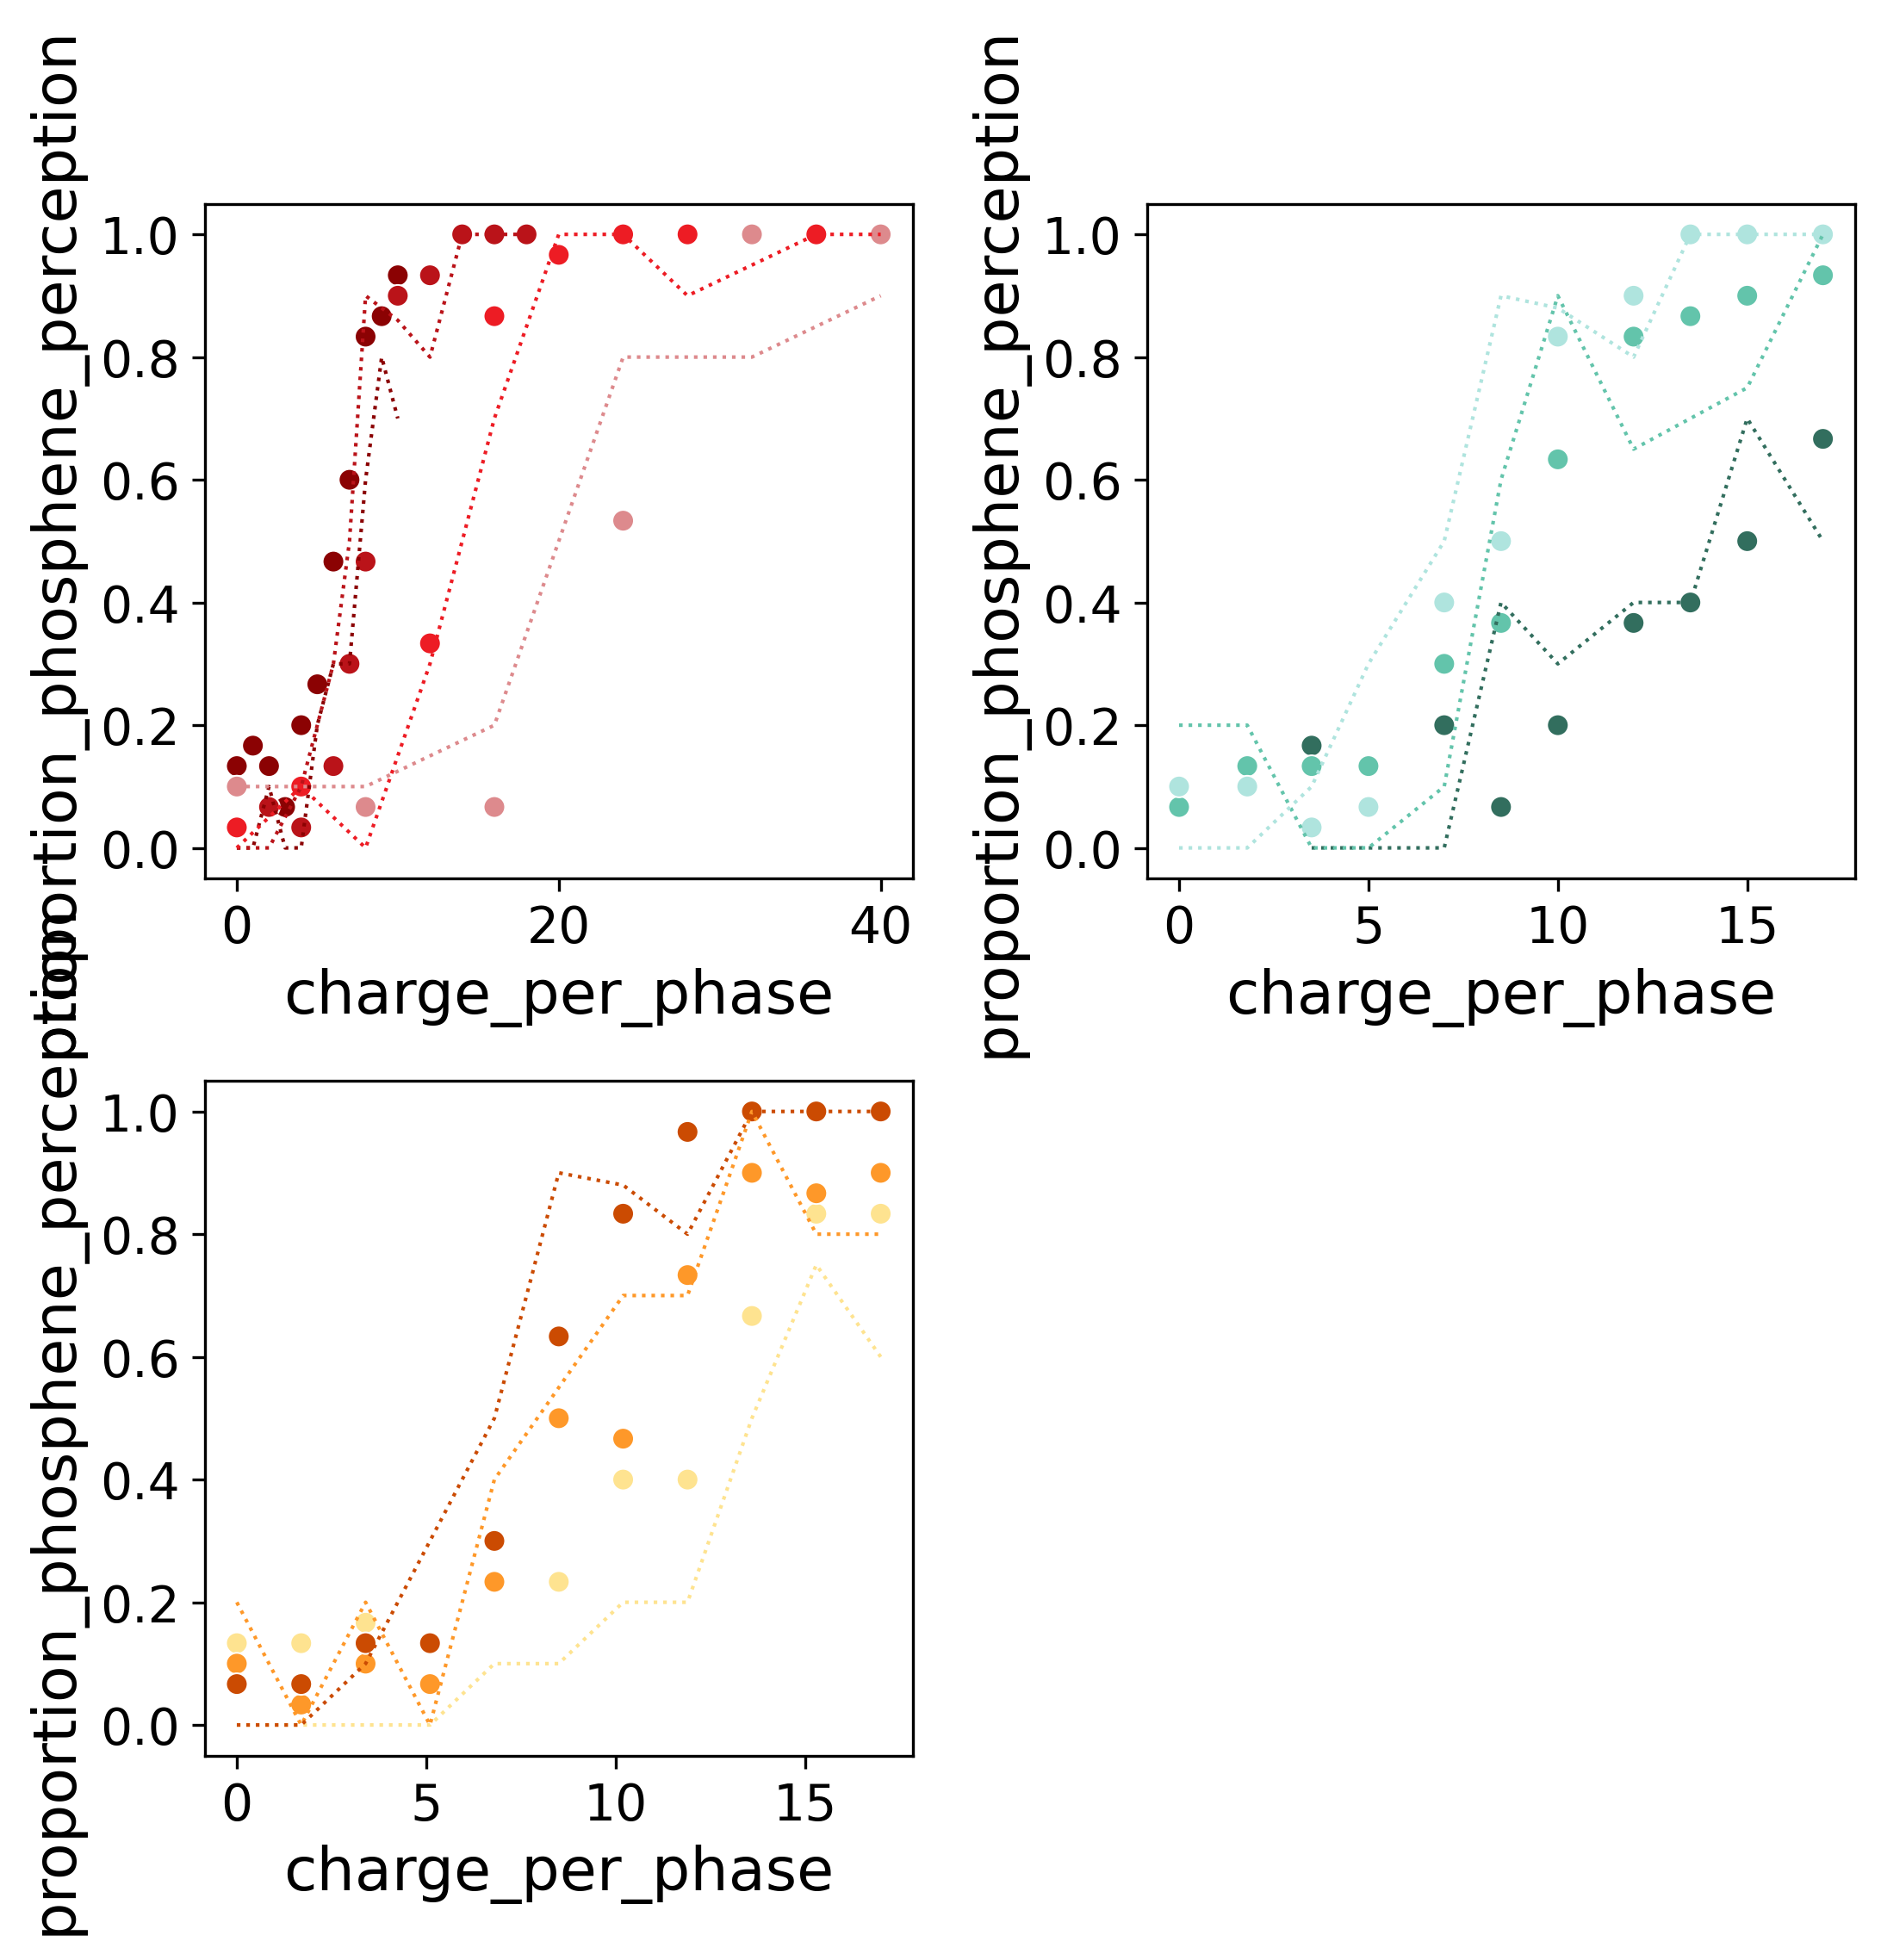

In [114]:
data['perc_active_'] = perc_active
fig, axs = plt.subplots(2,2, figsize=(7.5,7), dpi=300)
for i, (label, param, colors, xlim,) in enumerate([ ('fig2A','pulse_width', c_list_red, [None,None],),
                                                     ('fig2B','frequency', c_list_turq, [None,None]),
                                                     ('fig2C','train_duration', 'YlOrBr', [None,None])]):  #[0,17])]): 
# Lineplot (data)
    mask = data.label==label
    sns.lineplot(x = data.charge_per_phase[mask]*1e9,
                 y = y_true[mask],
                 hue = data.loc[mask,param],
                 palette=sns.color_palette(colors, n_colors=len(data[param].unique() )),
                 ax=axs.flatten()[i],
                 legend=False,
                 linewidth=1.,
                 linestyle = ':')    
    
    mask = data.label==label
    sns.scatterplot(x = data.charge_per_phase[mask]*1e9,
                 y = data.perc_active_[mask],
                 hue = data.loc[mask,param],
                 palette=sns.color_palette(colors, n_colors=len(data[param].unique() )),
                 ax=axs.flatten()[i],
                 legend=False,)
#                  linewidth=1.,
#                  linestyle = ':')    

axs[1,1].axis('off')
plt.tight_layout()